# DCGAN (Deep Convolutional Generative Adversarial Networks)
https://arxiv.org/pdf/1511.06434

In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [3]:
from IPython.display import display

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

def get_device():
    '''Get device (CPU or GPU).'''
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Network Models
### Generator
Random Noize -- ( Generator ) --> Fake images

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, image_size):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.unsqueeze(-1).unsqueeze(-1)  # Size([N, z_dim, 1, 1])
        z = self.layer1(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z)
        z = self.last(z)                   # Size([N, 1, image_size, image_size])
        return z

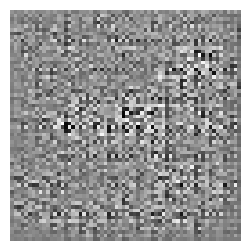

In [5]:
G = Generator(z_dim=20, image_size=4)
fake_images = G(torch.randn(1, 20))
plt.imshow(fake_images[0][0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

### Discriminator
Fake images -- ( Discriminator ) --> Score [Fake: 0, Real: 1]

In [6]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, image_size):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.last(x)
        return x

In [7]:
G = Generator(z_dim=20, image_size=4)
fake_images = G(torch.randn(1, 20))

D = Discriminator(z_dim=20, image_size=4)
d_out = D(fake_images)

print(nn.Sigmoid()(d_out))  # 0.0: Judged as fake, 0.5: Undecided, 1.0: Judged as real.

tensor([[[[0.5006]]]], grad_fn=<SigmoidBackward0>)


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def build_GAN(z_dim=20, image_size=64):
    G = Generator(z_dim=z_dim, image_size=image_size).apply(weights_init)
    D = Discriminator(z_dim=z_dim, image_size=image_size).apply(weights_init)
    return G, D

G, D = build_GAN(z_dim=20, image_size=64)
summary(G, [1, 20]), summary(D, [1, 1, 64, 64])

(==========================================================================================
 Layer (type:depth-idx)                   Output Shape              Param #
 Generator                                [1, 1, 64, 64]            --
 ├─Sequential: 1-1                        [1, 512, 4, 4]            --
 │    └─ConvTranspose2d: 2-1              [1, 512, 4, 4]            164,352
 │    └─BatchNorm2d: 2-2                  [1, 512, 4, 4]            1,024
 │    └─ReLU: 2-3                         [1, 512, 4, 4]            --
 ├─Sequential: 1-2                        [1, 256, 8, 8]            --
 │    └─ConvTranspose2d: 2-4              [1, 256, 8, 8]            2,097,408
 │    └─BatchNorm2d: 2-5                  [1, 256, 8, 8]            512
 │    └─ReLU: 2-6                         [1, 256, 8, 8]            --
 ├─Sequential: 1-3                        [1, 128, 16, 16]          --
 │    └─ConvTranspose2d: 2-7              [1, 128, 16, 16]          524,416
 │    └─BatchNorm2d: 2-8      

## Loss Function

Binary Cross Entropy is used as the loss function:

$$
L(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$

<br>

Given that real images are labeled as $y = 1$ and fake images as $y = 0$, the loss is

$$
L(y, D(x)) =
\begin{cases}
  -\log(D(x))     & \text{if } y = 1 \quad (\text{real image}) \\
  -\log(1 - D(x)) & \text{if } y = 0 \quad (\text{fake image})
\end{cases}
$$
<br>

Early in training, the discriminator can easily see through fake images, which results in a very small loss ($-\log(1 - D(G(z))) \approx -\log(1) = 0$) and slows down the learning for the generator.<br>
To address this, the following loss is used instead, which provides stronger gradients when the discriminator confidently classifies fake images as fake.

$$
L = -\log(D(G(z)))
$$

## Dataset, Dataloader, Transformer

In [9]:
class ImageTransform():
    def __init__(self, mean, std):
        self.transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, image):
        return self.transform(image)

In [10]:
class TinyMnistDataset(Dataset):
    def __init__(self, root, train, keys, transform=None, download=True):
        self.dataset = datasets.MNIST(root=root, train=train, download=download)
        self.transform = transform

        self.indices = []
        for key in keys:
            key_indices = np.where(np.array(self.dataset.targets) == key)[0]
            self.indices += list(key_indices[:200])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image

In [11]:
MEAN = (0.5,)
STD = (0.5,)
batch_size = 64

train_dataset = TinyMnistDataset(
    root=DATA_ROOT, train=True, keys=[7, 8], transform=ImageTransform(MEAN, STD))

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.99MB/s]


## Train, Run inference


In [12]:
def train(G, D,criterion, g_optimizer, d_optimizer, data_loader, device):
    G.train()
    D.train()

    total_g_loss = 0
    total_d_loss = 0
    for images in data_loader:
        images = images.to(device)
        batch_size = images.shape[0]

        # -----------------------
        # 1. Train Discriminator
        # -----------------------
        # Generate realness scores from real images.
        d_out_real = D(images)

        # Generate realness scores from fake images.
        input_z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(input_z)
        d_out_fake = D(fake_images)

        # Prepare labels.
        label_real = torch.full((batch_size,), 1, dtype=torch.float).to(device)
        label_fake = torch.full((batch_size,), 0, dtype=torch.float).to(device)

        # Calculate the loss.
        d_loss_real = criterion(d_out_real.view(-1), label_real)
        d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
        d_loss = d_loss_real + d_loss_fake

        # Backpropagate the loss and update the discriminator.
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # -----------------------
        # 2. Train Generator
        # -----------------------
        # Generate fake images from random noise.
        input_z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(input_z)
        d_out_fake = D(fake_images)

        # Calculate the loss (This provides high loss when the discriminator see through fake images.)
        g_loss = criterion(d_out_fake.view(-1), label_real)

        # Backpropagate the loss and update the discriminator.
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    return total_g_loss / len(data_loader), total_d_loss / len(data_loader)


def train_GAN(G, D, criterion, g_optimizer, d_optimizer, data_loader, num_epochs):
    device = get_device()
    torch.backends.cudnn.benchmark = True

    G.to(device)
    D.to(device)
    for epoch in range(num_epochs):
        g_loss, d_loss = train(G, D, criterion, g_optimizer, d_optimizer, data_loader, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}')

In [13]:
num_epochs = 200
z_dim = 20
image_size = 64
g_lr, d_lr = 0.0001, 0.0004
beta1, beta2 = 0.0, 0.9

G, D = build_GAN(z_dim=z_dim, image_size=image_size)

criterion = nn.BCEWithLogitsLoss(reduction='mean')
g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

train_GAN(G, D, criterion, g_optimizer, d_optimizer, train_dataloader, num_epochs)

Epoch [1/200], g_loss: 1.0562, d_loss: 1.3426
Epoch [2/200], g_loss: 1.3354, d_loss: 0.5219
Epoch [3/200], g_loss: 2.4957, d_loss: 0.6762
Epoch [4/200], g_loss: 3.7613, d_loss: 0.0489
Epoch [5/200], g_loss: 4.2365, d_loss: 0.0577
Epoch [6/200], g_loss: 1.8580, d_loss: 1.5687
Epoch [7/200], g_loss: 2.8401, d_loss: 0.7682
Epoch [8/200], g_loss: 3.3028, d_loss: 0.2492
Epoch [9/200], g_loss: 6.0695, d_loss: 0.0336
Epoch [10/200], g_loss: 1.6128, d_loss: 1.3257
Epoch [11/200], g_loss: 3.7353, d_loss: 0.1162
Epoch [12/200], g_loss: 4.7023, d_loss: 0.0680
Epoch [13/200], g_loss: 4.6806, d_loss: 1.4008
Epoch [14/200], g_loss: 5.9895, d_loss: 0.9114
Epoch [15/200], g_loss: 3.8714, d_loss: 0.1240
Epoch [16/200], g_loss: 4.4368, d_loss: 0.1291
Epoch [17/200], g_loss: 3.6224, d_loss: 1.1762
Epoch [18/200], g_loss: 3.1861, d_loss: 0.2088
Epoch [19/200], g_loss: 3.6302, d_loss: 1.4147
Epoch [20/200], g_loss: 3.3560, d_loss: 0.8013
Epoch [21/200], g_loss: 2.9714, d_loss: 0.5368
Epoch [22/200], g_loss

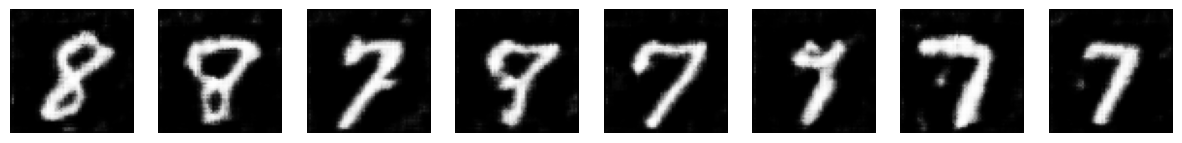

In [18]:
device = get_device()

batch_size = 8
z_dim = 20
input_z = torch.randn(batch_size, z_dim)

G.eval()
fake_images = G(input_z.to(device))

fig = plt.figure(figsize=(15, 6))
for i in range(batch_size):
    plt.subplot(1, batch_size, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    plt.axis('off')

plt.show()